# Create some of the figures used in this lecture

Using some Landsat 8 imagery.

In [1]:
from pathlib import Path
import skimage.io
import skimage.exposure
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Some utility functions.

In [2]:
def load_scene(folder, pattern):
    """
    Read the images from a folder and returm them in a dictionary.
    """
    files = list(Path(folder).glob(f"*_B{pattern}.TIF"))
    assert files
    scene = dict()
    for fname in files:
        band = int(str(fname)[:-4].split("_")[-1][1:])
        scene[band] = skimage.io.imread(fname)
    return scene


def crop_scene(scene, region):
    """
    Crop all bands in a scene to the given pixel interval.
    """
    w, e, s, n = region
    cropped = dict()
    for band in scene:
        cropped[band] = scene[band][s:n, w:e]
    return cropped

## Prepare the scenes

First, we'll load some scenes and do some initial cropping to make it smaller and more informative.

The cropped images were generated from a full scene using the following code:

```python
region = np.array([4500, 6100, 2200, 3600])
liverpool = crop_scene(
    load_scene(
        "LC08_L2SP_204023_20200927_20201006_02_T1/", 
        pattern="[0-9]*",
    ),
    region,
)
liverpool_pan = crop_scene(
    load_scene(
        "LC08_L1TP_204023_20200927_20201006_02_T1/", 
        pattern="[8]",
    ),
    region * 2,
)

# Save the cropped data to the repository
data_folder = Path("../../data/liverpool/")
scenes = [liverpool, liverpool_pan]
destinations = [
    data_folder / "LC08_L2SP_204023_20200927_20201006_02_T1_cropped",
    data_folder / "LC08_L1TP_204023_20200927_20201006_02_T1_cropped",
]
for scene, destination in zip(scenes, destinations):
    destination.mkdir(exist_ok=True)
    for band in scene:
        fname = destination / f"cropped_B{band}.TIF"
        skimage.io.imsave(fname, scene[band])
```        

Now that the cropped version is stored, we can load it instead of the full scene to save memory and storage.

In [3]:
liverpool = load_scene(
    Path("../../data/liverpool/LC08_L2SP_204023_20200927_20201006_02_T1_cropped/"),
    pattern="[0-9]*",
)
liverpool_pan = load_scene(
    Path("../../data/liverpool/LC08_L1TP_204023_20200927_20201006_02_T1_cropped/"),
    pattern="[8]",
)

## Plot all bands in a scene

To ilustrate their differences and sensitivities.

In [4]:
band_names = {
    1: "Aerosol",
    2: "Blue",
    3: "Green",
    4: "Red",
    5: "NIR",
    6: "SWIR 1",
    7: "SWIR 2",
    10: "Thermal",
}

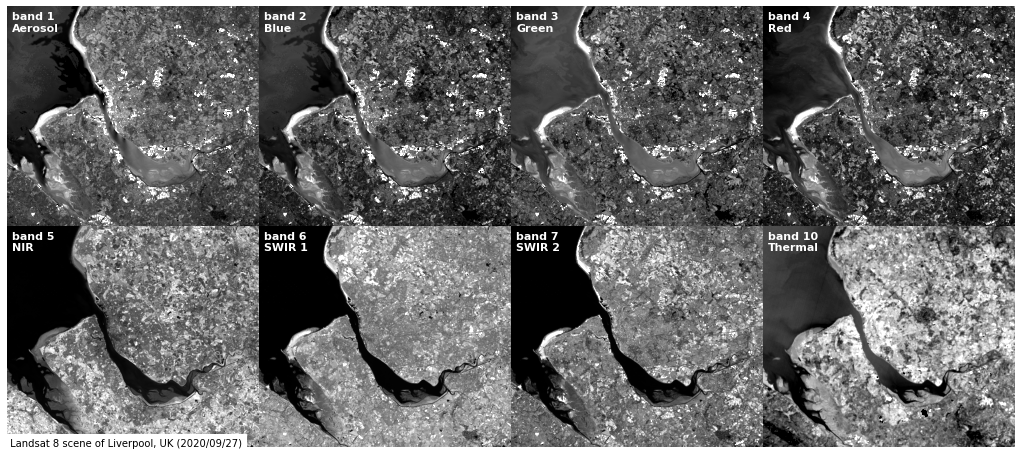

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6.15))
for ax, band in zip(axes.ravel(), [1, 2, 3, 4, 5, 6, 7, 10]):    
    vmin, vmax = np.percentile(liverpool[band], (2, 98))
    ax.imshow(liverpool[band], cmap="gray", vmin=vmin, vmax=vmax)
    ax.axis("off")
    ax.text(
        30, 30, 
        f"band {band}\n{band_names[band]}", 
        color="white", 
        fontweight="bold", 
        fontsize=11,
        verticalalignment="top",
    )
fig.text(0, 0, 
    " Landsat 8 scene of Liverpool, UK (2020/09/27)", 
    color="black", 
    fontweight="normal", 
    fontsize=10,
    verticalalignment="bottom",
    backgroundcolor="white",
)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig("../images/landsat8-bands-liverpool.svg", bbox_inches="tight", pad_inches=0)

## Comparison of panchromatic and other bands

Plot a true color composite and the panchromatic band to show the difference in resolution.

In [6]:
region = np.array([200, 700, 330, 500])
color = crop_scene(liverpool, region)
panchromatic = crop_scene(liverpool_pan, region * 2)

In [7]:
nrows, ncols = color[2].shape
truecolor = np.empty((nrows, ncols, 3), dtype="uint8")
in_range = (5000, 18000)
for i, band in enumerate([4, 3, 2]):
    truecolor[:, :, i] = skimage.exposure.rescale_intensity(color[band], in_range=in_range, out_range="uint8")

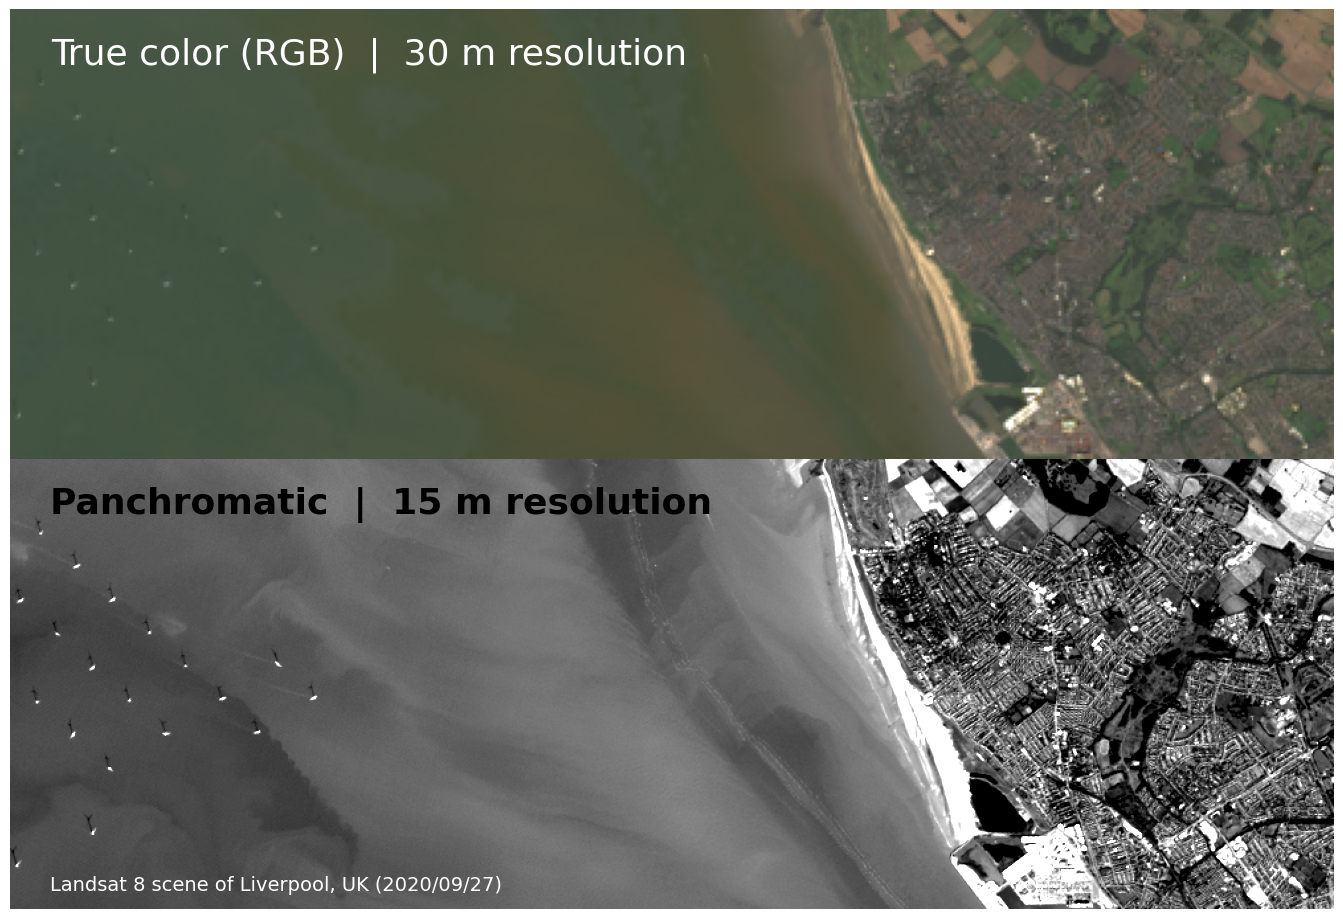

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(14, 9), dpi=100)
axes[0].imshow(truecolor)
vmin, vmax = np.percentile(panchromatic[8], (3, 97))
axes[1].imshow(panchromatic[8], cmap="gray", vmin=vmin, vmax=vmax)
axes[0].text(15, 20, "True color (RGB)  |  30 m resolution", color="white", fontsize=26)
axes[1].text(30, 40, "Panchromatic  |  15 m resolution", color="black", fontsize=26, fontweight="bold")
axes[1].text(30, panchromatic[8].shape[0] - 15, "Landsat 8 scene of Liverpool, UK (2020/09/27)", color="white", fontsize=14)
for ax in axes:
    ax.axis("off")
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig("../images/panchromatic-rbg-resolution.svg", bbox_inches="tight", pad_inches=0)

## Example of composites

Create a visualization of true color and CIR composites using our images.

In [9]:
nrows, ncols = liverpool[2].shape
truecolor = np.empty((nrows, ncols, 3), dtype="uint8")
in_range = (5000, 18000)
for i, band in enumerate([4, 3, 2]):
    truecolor[:, :, i] = skimage.exposure.rescale_intensity(liverpool[band], in_range=in_range, out_range="uint8")

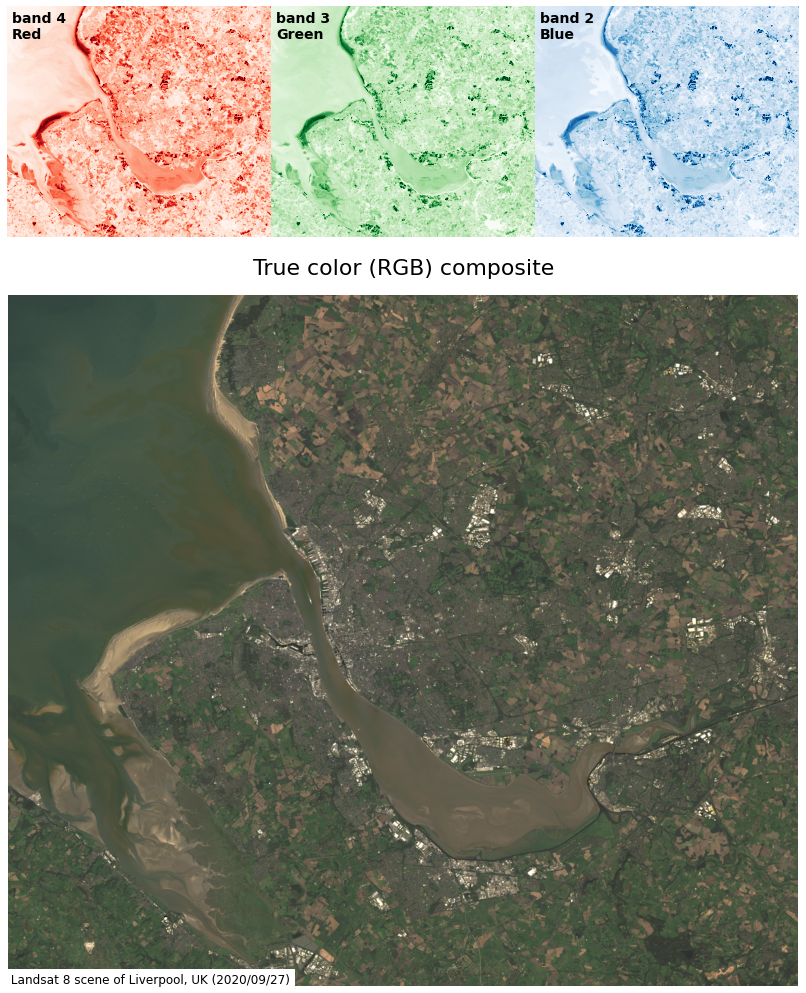

In [10]:
fig = plt.figure(figsize=(11, 14.4))
grid = GridSpec(3, 3, figure=fig, wspace=0, hspace=0)
axes =[
    fig.add_subplot(grid[0, 0]),
    fig.add_subplot(grid[0, 1]),
    fig.add_subplot(grid[0, 2]),
]
cmaps = ["Reds", "Greens", "Blues"]
for ax, band, cmap in zip(axes, [4, 3, 2], cmaps):    
    vmin, vmax = np.percentile(liverpool[band], (1, 99))
    ax.imshow(liverpool[band], cmap=cmap, vmin=vmin, vmax=vmax)
    ax.axis("off")
    ax.text(
        30, 30, 
        f"band {band}\n{band_names[band]}", 
        color="black", 
        fontweight="bold", 
        fontsize=14,
        verticalalignment="top",
    )    
ax = fig.add_subplot(grid[1:, 0:])
ax.axis("off")
ax.imshow(truecolor)
ax.set_title("True color (RGB) composite", fontsize=22, pad=20)

fig.text(0, 0, 
    " Landsat 8 scene of Liverpool, UK (2020/09/27)", 
    color="black", 
    fontweight="normal", 
    fontsize=12,
    verticalalignment="bottom",
    backgroundcolor="white",
)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig("../images/rgb-composite-liverpool.svg", bbox_inches="tight", pad_inches=0)

In [11]:
nrows, ncols = liverpool[2].shape
cir = np.empty((nrows, ncols, 3), dtype="uint8")
in_range = (5000, 18000)
for i, band in enumerate([5, 4, 3]):
    cir[:, :, i] = skimage.exposure.rescale_intensity(liverpool[band], in_range=in_range, out_range="uint8")

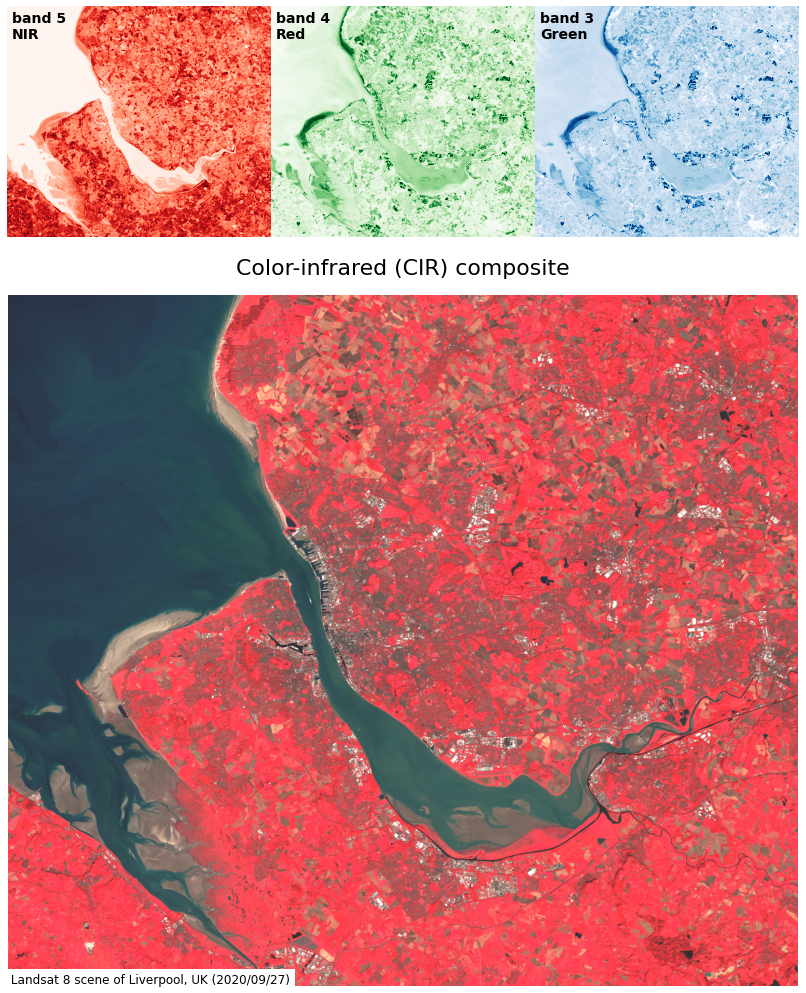

In [12]:
fig = plt.figure(figsize=(11, 14.4))
grid = GridSpec(3, 3, figure=fig, wspace=0, hspace=0)
axes =[
    fig.add_subplot(grid[0, 0]),
    fig.add_subplot(grid[0, 1]),
    fig.add_subplot(grid[0, 2]),
]
cmaps = ["Reds", "Greens", "Blues"]
for ax, band, cmap in zip(axes, [5, 4, 3], cmaps):    
    vmin, vmax = np.percentile(liverpool[band], (1, 99))
    ax.imshow(liverpool[band], cmap=cmap, vmin=vmin, vmax=vmax)
    ax.axis("off")
    ax.text(
        30, 30, 
        f"band {band}\n{band_names[band]}", 
        color="black", 
        fontweight="bold", 
        fontsize=14,
        verticalalignment="top",
    )    
ax = fig.add_subplot(grid[1:, 0:])
ax.axis("off")
ax.imshow(cir)
ax.set_title("Color-infrared (CIR) composite", fontsize=22, pad=20)

fig.text(0, 0, 
    " Landsat 8 scene of Liverpool, UK (2020/09/27)", 
    color="black", 
    fontweight="normal", 
    fontsize=12,
    verticalalignment="bottom",
    backgroundcolor="white",
)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig("../images/cir-composite-liverpool.svg", bbox_inches="tight", pad_inches=0)